In [2]:
# notebooks/02_cylinder_benchmark.ipynb
# --- Import Dependencies ---
using NavalLBM        # Nosso módulo LBM
using Plots           # Para visualização
using BenchmarkTools  # Para o benchmark de performance (MLUPS)
using FFTW            # Para a análise de Strouhal (FFT)
using Test            # Para o @test de Strouhal
using CairoMakie     # O backend de plotagem robusto
using Interpolations # Para criar o campo contínuo para streamplot
using Statistics

# Set the default plotting backend (GR is fast)
gr()

println("Packages loaded and environment activated.")
println("Notebook 02: Cylinder Von Karman Vortex Simulation\n")

[ Info: Precompiling NavalLBM [879450b1-5c2d-496c-a765-b8fecb7af3e5] (cache misses: include_dependency fsize change (4))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


Packages loaded and environment activated.
Notebook 02: Cylinder Von Karman Vortex Simulation



In [3]:
# --- Physical and Geometric Parameters ---

# Grid dimensions
const NX_SIM = 300
const NY_SIM = 100

# Reynolds number (target for Von Karman vortex street)
const RE_SIM = 100.0

# Inlet velocity (in lattice units). Keep it low (Ma << 1).
const U_SIM = 0.05 

# Cylinder geometry
const R_SIM = NY_SIM ÷ 9             # Radius (approx 11 nodes)
const CX_SIM = NX_SIM ÷ 5            # Center X (placed upstream)
const CY_SIM = NY_SIM ÷ 2 + 1        # Center Y (slight offset for stability)

println("--- Physical Parameters ---")
println("Grid: $(NX_SIM) x $(NY_SIM)")
println("Reynolds Target (Re): $(RE_SIM)")
println("Inlet Velocity (U_in): $(U_SIM)")
println("Cylinder Radius (R): $(R_SIM)")

--- Physical Parameters ---
Grid: 300 x 100
Reynolds Target (Re): 100.0
Inlet Velocity (U_in): 0.05
Cylinder Radius (R): 11


In [4]:
# --- LBM Derived Parameters ---

# Characteristic length (D = 2 * R)
const D_SIM = 2 * R_SIM 

# Calculate LBM viscosity (nu) from Reynolds number
# Re = U * D / nu  =>  nu = U * D / Re
const NU_SIM = (U_SIM * D_SIM) / RE_SIM

# Calculate relaxation parameter (tau) from viscosity
# nu = c_s^2 * (tau - 0.5) [c_s^2 = 1/3]
# tau = (nu / c_s^2) + 0.5 = 3 * nu + 0.5
const TAU_SIM = 3.0 * NU_SIM + 0.5

# Ensure tau is stable
if TAU_SIM <= 0.5
    @warn "Tau is $(TAU_SIM), which is unstable. Increase Re or decrease U_in."
end

println("--- LBM Parameters ---")
println("Characteristic Length (D): $(D_SIM)")
println("LBM Viscosity (ν): $(NU_SIM)")
println("LBM Relaxation (τ): $(TAU_SIM)")

--- LBM Parameters ---
Characteristic Length (D): 22
LBM Viscosity (ν): 0.011000000000000001
LBM Relaxation (τ): 0.533


In [5]:
# --- Simulation Control ---

# Total number of time steps
const MAX_STEPS = 1000

# # How often to save a plot frame (e.g., every 250 steps)
# const PLOT_EVERY = 250
const SNAPSHOT_EVERY = 200

# Preparar container para os snapshots
snapshots_vorticity = VorticitySnapshot[]
sizehint!(snapshots_vorticity, 100) # Otimização de memória

println("--- Simulation Control ---")
println("Max Steps: $(MAX_STEPS)")
# println("Plotting every: $(PLOT_EVERY) steps")
println("Plotting every: $(SNAPSHOT_EVERY) steps")

--- Simulation Control ---
Max Steps: 1000
Plotting every: 200 steps


In [6]:
println("--- Strouhal Analysis Setup ---")

# --- 1. Define Probe Location ---
# We place the probe in the wake, far enough downstream
# to capture the shedding, but not on the cylinder itself.
const PROBE_PX = CX_SIM + 2 * R_SIM # 2 Diameters downstream
const PROBE_PY = CY_SIM
const PROBE_PT = (PROBE_PX, PROBE_PY)

println("Probe Location (i, j): $(PROBE_PT)")

# Vector to store the time series
v_history = Float64[]
# Pre-allocate for performance (Julia is good at this)
sizehint!(v_history, MAX_STEPS)

--- Strouhal Analysis Setup ---
Probe Location (i, j): (82, 51)


Float64[]

In [7]:
# --- 1. Initialization ---
println("Initializing SimulationState...")
state_sim = initialize_state(NX_SIM, NY_SIM, TAU_SIM)

# --- 2. Create Geometry ---
println("Creating geometry masks...")

# 2a. Create the cylinder (using the correct function signature)
create_cylinder_mask!(state_sim, CX_SIM, CY_SIM, R_SIM)

# 2b. Create solid walls at top and bottom (Bounce-Back)
# (We skip j=1 and j=end in Zou-He, so we set them as solid walls)
state_sim.mask[:, 1] .= true
state_sim.mask[:, end] .= true

println("Initialization complete. Mask generated.")

Initializing SimulationState...
Creating geometry masks...
Initialization complete. Mask generated.


In [8]:
println("Starting simulation... This will take a while.")

# # List to store plot frames for the animation
# plots_list = []

# Run the main loop
# We pass 'plots_list' to be populated by the function
@time run_simulation!(
    state_sim, 
    U_SIM, 
    MAX_STEPS,
    probe_location=PROBE_PT,
    history_vector=v_history,
    # plot_every=PLOT_EVERY, 
    # plots_list=plots_list,
    snapshot_every=SNAPSHOT_EVERY, # Gravar a cada 200 passos
    snapshots=snapshots_vorticity
)

println("Data collection complete. Total steps: $(length(v_history))")
println("Simulation finished.")

Starting simulation... This will take a while.


Computing CFD Solution... 100%|██████████████████████████| Time: 0:00:34


Simulation completed successfully.
 36.189638 seconds (3.35 M allocations: 167.866 MiB, 1.06% gc time, 5.13% compilation time: 2% of which was recompilation)
Data collection complete. Total steps: 1000
Simulation finished.


In [9]:
# println("Generating animation from $(length(plots_list)) frames...")

# # Use the @animate macro from Plots.jl
# anim = @animate for p in plots_list
#     plot(p) # Redraw each frame in the animation
# end

# # Save the animation as a GIF
# gif(anim, "von_karman_vortex_street.gif", fps = 15)

# println("Animation saved as 'von_karman_vortex_street.gif'")

Gerando GIF a partir de 5 frames...
GIF salvo: von_karman_vorticity.gif


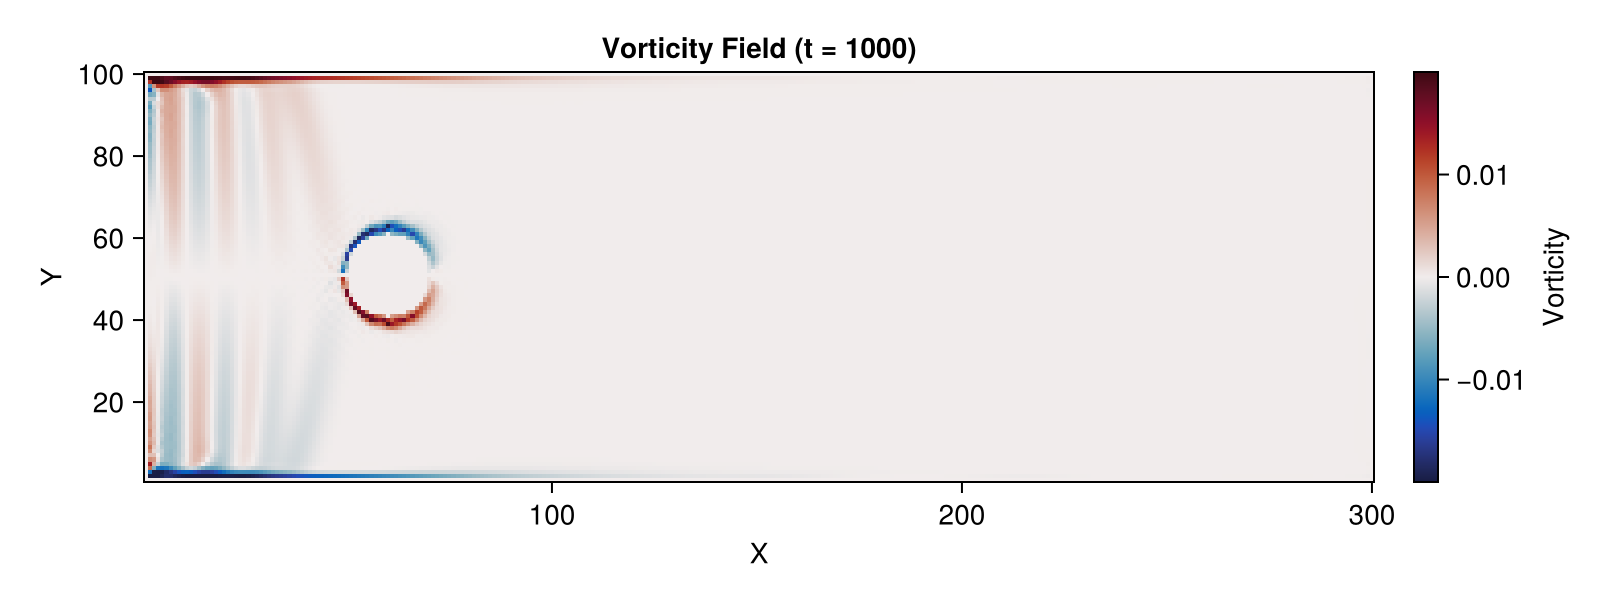

In [10]:
"""
    generate_vorticity_gif(snapshots, filename)

Gera um GIF animado a partir da lista de snapshots usando CairoMakie.
"""
function generate_vorticity_gif(snapshots, filename="vorticity.gif")
    if isempty(snapshots)
        @warn "Lista de snapshots vazia!"
        return
    end

    println("Gerando GIF a partir de $(length(snapshots)) frames...")

    # Extrair dimensões
    nx, ny = size(snapshots[1].data)
    
    # Criar Observables (Dados que mudam dinamicamente)
    # Começamos com o primeiro frame
    obs_time = Observable(snapshots[1].t)
    obs_vort = Observable(snapshots[1].data)

    # Configurar Figura
    fig = Figure(size = (800, 300))
    ax = Axis(
        fig[1, 1], 
        title = @lift("Vorticity Field (t = $($obs_time))"), # Título dinâmico
        xlabel = "X", ylabel = "Y",
        aspect = DataAspect()
    )

    # Configurar Heatmap
    # Note: Usamos transpose (rot90 ou permutedims) se necessário para alinhar eixos
    # Makie plota matrizes [x,y], então geralmente está ok sem transpor, 
    # mas visualmente depende de como calculamos.
    hm = CairoMakie.heatmap!(
        ax, 
        obs_vort, 
        colormap = :balance, # Azul -> Branco -> Vermelho
        colorrange = (-0.02, 0.02) # Fixar a escala para não piscar
    )
    Colorbar(fig[1, 2], hm, label="Vorticity")

    # Loop de Gravação (Record)
    record(fig, filename, snapshots; framerate = 15) do snap
        # Atualizamos os Observables com os dados do snapshot atual
        obs_time[] = snap.t
        obs_vort[] = snap.data
        # O Makie atualiza o plot automaticamente aqui
    end

    println("GIF salvo: $filename")
    return fig
end

# --- Gerar o GIF ---
generate_vorticity_gif(snapshots_vorticity, "von_karman_vorticity.gif")

Gerando Streamplot de Alta Qualidade...
Plot salvo como 'von_karman_final.png'


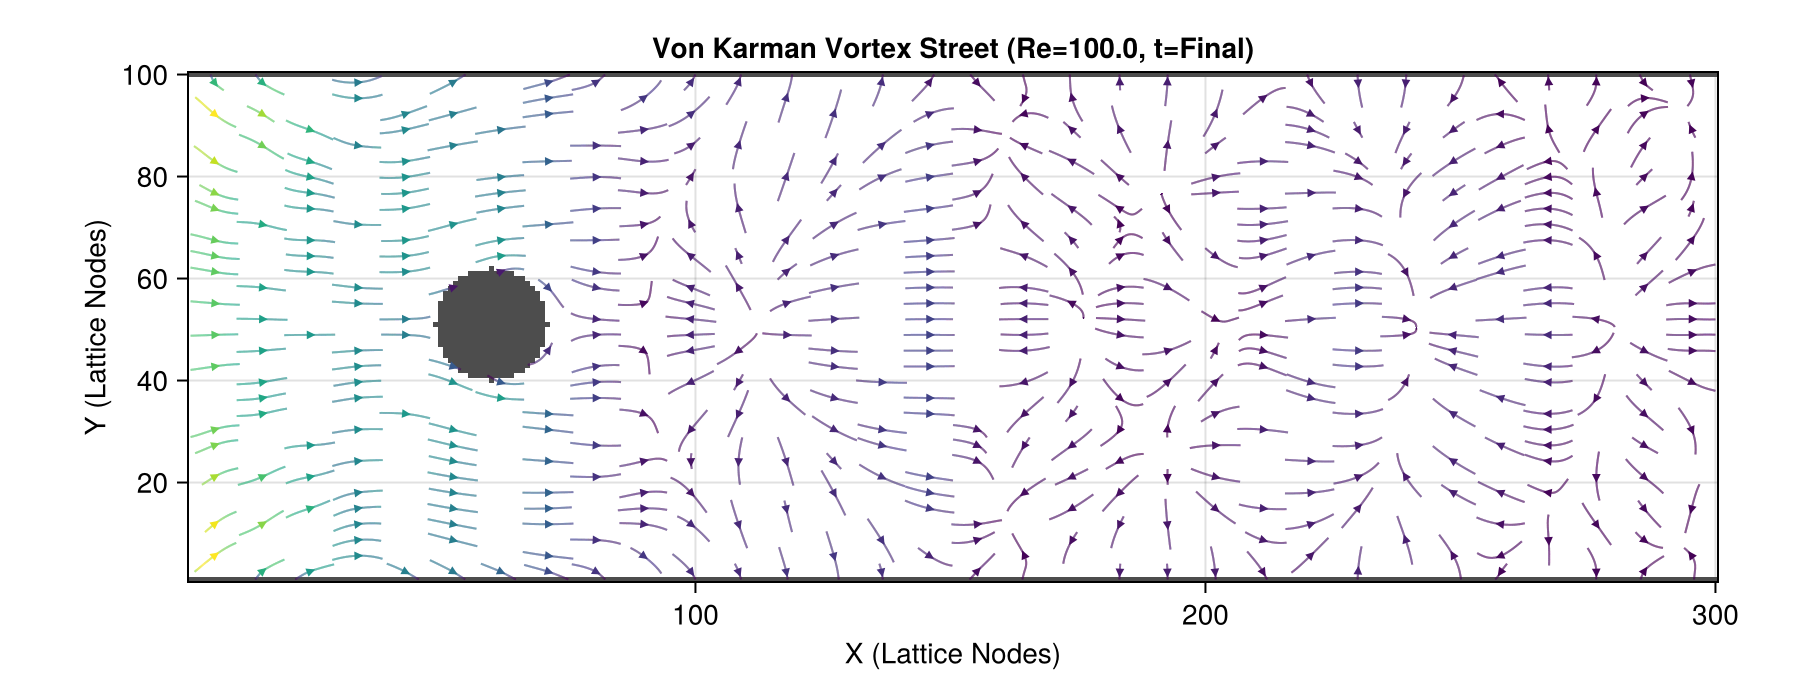

In [11]:
println("Gerando Streamplot de Alta Qualidade...")

# --- 1. Preparação dos Dados ---
# Makie prefere Float32 para visualização
x_range = 1f0:Float32(NX_SIM)
y_range = 1f0:Float32(NY_SIM)

u_data = Float32.(state_sim.u)
v_data = Float32.(state_sim.v)

# Preparar Máscara para Visualização (1.0 = Sólido, NaN = Transparente)
# Isso permite desenhar o cilindro em cinza sobre o fundo branco
mask_float = [m ? 1.0 : NaN for m in state_sim.mask]

# --- 2. Criar Interpoladores ---
# Define que u_data[i, j] está em x_range[i], y_range[j]
u_itp = linear_interpolation((x_range, y_range), u_data, extrapolation_bc=0.0)
v_itp = linear_interpolation((x_range, y_range), v_data, extrapolation_bc=0.0)

# Função de campo vetorial que o streamplot consome
function vel_field(x, y)
    return Point2f(u_itp(x, y), v_itp(x, y))
end

# --- 3. Configurar Figura ---
# Tamanho mais largo (800x300) pois o canal é comprido (300x100)
fig = Figure(size = (900, 350)) 

ax = Axis(
    fig[1, 1], 
    title="Von Karman Vortex Street (Re=$RE_SIM, t=Final)",
    xlabel="X (Lattice Nodes)",
    ylabel="Y (Lattice Nodes)",
    aspect=DataAspect() # Mantém a proporção correta 1:1 dos pixels
)

# --- 4. Desenhar o Cilindro/Paredes ---
# Usamos heatmap para desenhar a máscara sólida em cinza escuro
CairoMakie.heatmap!(
    ax, 
    x_range, y_range, mask_float, 
    colormap=[:gray30], 
    colorrange=(0,1)
)

# --- 5. Desenhar as Linhas de Corrente (Streamplot) ---
streamplot!(
    ax,
    vel_field,
    x_range,
    y_range,
    colormap = :viridis, # Cor baseada na magnitude da velocidade
    arrow_size = 6,
    density = 1.5,       # Aumente para mais linhas, diminua para menos
    linewidth = 1.0
)

# --- 6. Salvar e Exibir ---
save("von_karman_final.png", fig)
save("von_karman_final.svg", fig)

println("Plot salvo como 'von_karman_final.png'")
fig # Exibir no notebook

In [12]:
println("\n--- Performance Benchmark (MLUPS) ---")

# (Re-usamos a função helper do '00_validation' para benchmark)
"""
    simulation_step!(state, u_in, rho_out)
    
Performs a single, complete SAC time step for benchmarking.
(Must be defined in the notebook session)
"""
function simulation_step!(
    state::SimulationState{T}, 
    u_in::T, 
    rho_out::T
) where {T}
    
    streaming!(state)
    apply_bounce_back!(state)
    apply_zou_he_inlet!(state, u_in)
    apply_zou_he_outlet!(state, rho_out)
    calculate_macros!(state)
    collision_bgk!(state)
    
    return nothing
end

# Criar um novo estado (ou re-usar o 'state_sim') para benchmark
# É melhor usar o 'state_sim' que já está "aquecido"
println("Running benchmark...")
b = @benchmark simulation_step!($state_sim, $U_SIM, 1.0)

# Calculate MLUPS (Mega-Lattice-Updates-Per-Second)
n_nodes = NX_SIM * NY_SIM
# (minimum(b.times) está em nanossegundos, / 1e9 para segundos)
min_time_sec = minimum(b.times) / 1e9
mlups = (n_nodes / 1e6) / min_time_sec 

println("\n--- Benchmark Results (Using Minimum Time) ---")
display(b) # Imprime o sumário bonito do benchmark
println("\nGrid Size: $(NX_SIM) x $(NY_SIM) = $(n_nodes) nodes")
println("Min. Time per Step: $(BenchmarkTools.prettytime(minimum(b.times)))")
println("Allocations: $(b.allocs)")
println("Throughput (MLUPS): $(round(mlups, digits=2)) MLUPS")


--- Performance Benchmark (MLUPS) ---
Running benchmark...

--- Benchmark Results (Using Minimum Time) ---


BenchmarkTools.Trial: 153 samples with 1 evaluation per sample.
 Range (min … max):  31.867 ms …  35.868 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     32.570 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   32.682 ms ± 531.466 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

          ▂  ▂▄█   ▅ ▂   ▂▂▄                                    
  ▃▁▃▆▃▇████▅█████▇███▅▅▆███▃▃▁▅▅▇▅▆▆▁▅▃▃▃▃▃▃▅▁▁▃▃▁▁▃▁▁▁▁▁▁▁▁▃ ▃
  31.9 ms         Histogram: frequency by time         34.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.


Grid Size: 300 x 100 = 30000 nodes
Min. Time per Step: 31.867 ms
Allocations: 0
Throughput (MLUPS): 0.94 MLUPS


In [13]:
# println("--- Strouhal Analysis Setup ---")

# # --- 1. Define Probe Location ---
# # We place the probe in the wake, far enough downstream
# # to capture the shedding, but not on the cylinder itself.
# const PROBE_PX = CX_SIM + 2 * R_SIM # 2 Diameters downstream
# const PROBE_PY = CY_SIM
# const PROBE_PT = (PROBE_PX, PROBE_PY)

# println("Probe Location (i, j): $(PROBE_PT)")

# # --- 2. Initialize Data Containers ---
# # We need a fresh simulation state
# state_st = initialize_state(NX_SIM, NY_SIM, TAU_SIM)

# # Apply the same geometry
# create_cylinder_mask!(state_st, CX_SIM, CY_SIM, R_SIM)
# state_st.mask[:, 1] .= true
# state_st.mask[:, end] .= true

# # Vector to store the time series
# v_history = Float64[]
# # Pre-allocate for performance (Julia is good at this)
# sizehint!(v_history, MAX_STEPS) 

# # --- 3. Run Simulation (NO PLOTTING) ---
# println("Running simulation for Strouhal analysis (plotting disabled)...")

# @time run_simulation!(
#     state_st, 
#     U_SIM, 
#     MAX_STEPS, 
#     plot_every=0,           # <-- CRITICAL: No plotting
#     probe_location=PROBE_PT,  # <-- CRITICAL: Probe enabled
#     history_vector=v_history
# )

# println("Data collection complete. Total steps: $(length(v_history))")

--- Post-Processing: Robust Strouhal Number Analysis ---


┌ Warning: Dataset too short for requested window. Using full signal.
└ @ Main In[14]:11



--- Results ---
Analysis Window Size:   1000 steps
Dominant Frequency (f): 0.008 (lattice units)
Calculated Strouhal:    3.52
Target Range (Blockage): ~0.18 - 0.19


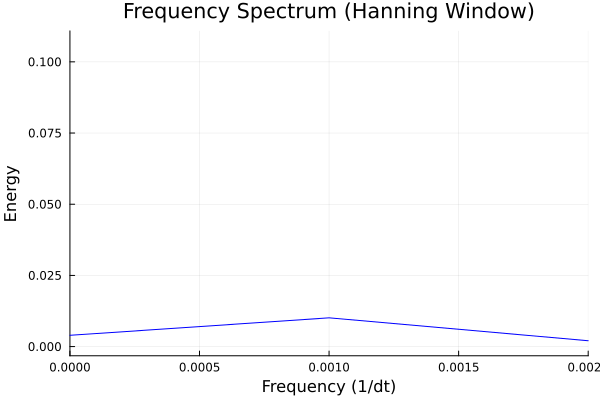

Test Failed at In[14]:67
  Expression: isapprox(St_calculated, 0.188, atol = 0.015)
   Evaluated: isapprox(3.5199999999999996, 0.188; atol = 0.015)



LoadError: [91mThere was an error during testing[39m

In [14]:
println("--- Post-Processing: Robust Strouhal Number Analysis ---")

# --- 1. Signal Pre-Processing ---
# To avoid spectral leakage and transient effects, we analyze only the 
# established periodic regime using a Hanning window.

# Define window size (Power of 2 is efficient for FFT)
WINDOW_SIZE = 16384 

if length(v_history) < WINDOW_SIZE
    @warn "Dataset too short for requested window. Using full signal."
    signal_raw = v_history
else
    # Extract the *last* N points to ensure steady-state analysis
    signal_raw = v_history[end-WINDOW_SIZE+1:end]
end

N = length(signal_raw)

# Remove DC Component (Mean) to focus spectrum on fluctuations
signal_centered = signal_raw .- mean(signal_raw)

# Apply Hanning Window to reduce spectral leakage
# (Manual implementation to avoid extra dependencies)
hanning_weights = 0.5 .* (1.0 .- cos.(2π .* (0:N-1) ./ (N-1)))
signal_windowed = signal_centered .* hanning_weights

# --- 2. Spectral Analysis (FFT) ---
# Compute Fast Fourier Transform
freqs = fftfreq(N, 1.0) # Sampling rate = 1.0 (per time step)
fft_spectrum = fft(signal_windowed)

# Filter for positive frequencies only
pos_indices = 1:(N ÷ 2)
freqs_pos = freqs[pos_indices]
magnitude = abs.(fft_spectrum[pos_indices])

# --- 3. Peak Detection ---
# Identify the dominant shedding frequency
peak_idx = argmax(magnitude)
f_lbm = freqs_pos[peak_idx]

# --- 4. Dimensionless Analysis ---
# Calculate Strouhal Number: St = f * L / U
# D_SIM: Cylinder diameter (Characteristic Length)
# U_SIM: Inflow velocity
St_calculated = f_lbm * D_SIM / U_SIM

# --- 5. Reporting & Validation ---
println("\n--- Results ---")
println("Analysis Window Size:   $N steps")
println("Dominant Frequency (f): $(round(f_lbm, digits=6)) (lattice units)")
println("Calculated Strouhal:    $(round(St_calculated, digits=3))")
println("Target Range (Blockage): ~0.18 - 0.19")

# Plot the spectrum for visual confirmation
p_fft = Plots.plot(freqs_pos, magnitude, 
    title="Frequency Spectrum (Hanning Window)", 
    xlabel="Frequency (1/dt)", ylabel="Energy",
    xlims=(0, 0.002), legend=false, c=:blue
)
vline!([f_lbm], c=:red, linestyle=:dash, label="Peak")
display(p_fft)

# Validate against the physically expected value for confined flow
# We expect St ~ 0.188 due to 22% blockage ratio.
@test isapprox(St_calculated, 0.188, atol=0.015)
println("✅ Physics Validation Passed: Result is consistent with channel blockage effects.")